In [60]:
import pandas as pd
import numpy as np

# Datos de ejemplo
#data = {
#    'user_id': [6, 3, 7, 4, 6, 9, 2, 6, 7, 4, 3, 7, 7, 2, 5, 4, 1, 7, 5, 1, 4, 0, 9, 5, 8, 0, 9, 2, 6, 3, 8, 2, 4, 2, 6, 4, 8, 6, 1, 3, 8, 1, 9, 8, 9, 4, 1, 3, 6, 7],
#    'book_id': [14, 2, 13, 16, 3, 17, 7, 3, 1, 5, 9, 3, 17, 11, 1, 9, 3, 13, 15, 14, 7, 13, 7, 15, 12, 17, 14, 12, 8, 14, 12, 0, 6, 8, 0, 11, 7, 10, 18, 16, 7, 2, 2, 0, 4, 9, 6, 8, 6, 8],
#    'rating': [4, 2, 1, 5, 3, 4, 3, 3, 1, 3, 5, 3, 1, 5, 2, 3, 1, 2, 2, 4, 5, 3, 1, 4, 5, 4, 5, 5, 3, 5, 4, 5, 3, 3, 4, 2, 2, 5, 1, 5, 4, 4, 4, 4, 4, 3, 2, 4, 1, 1]
#}

data = {
   'user_id': [0, 0, 0, 1, 1, 2, 2, 3],
   'book_id': [1, 2, 3, 1, 2, 1, 4, 4],
   'rating': [5, 5, 5, 4, 5, 5, 1, 1]
}

df = pd.DataFrame(data)
df['book_id'] = df['book_id'] - 1
print(len(df))
df.head()

8


,user_id,book_id,rating
0,0,0,5
1,0,1,5
2,0,2,5
3,1,0,4
4,1,1,5


In [81]:
import tensorflow as tf
import pandas as pd

# Definición del modelo y las funciones auxiliares
def buildSparseTensorRatings(df, dense_shape):
    return tf.sparse.SparseTensor(
        indices=df[['user_id', 'book_id']].values,
        values=df['rating'].values,
        dense_shape=dense_shape
    )

class CFModel:
    def __init__(self, embeddings, l2_reg=0.01, dropout_rate=0.5):
        self.embeddings = embeddings
        self.l2_reg = l2_reg
        self.dropout_rate = dropout_rate

    def train(self, tensor_train, tensor_val, num_iterations=1000, learning_rate=0.01, verbosity=1):
        U = self.embeddings['user']
        V = self.embeddings['item']

        optimizer = tf.optimizers.Adam(learning_rate)

        for i in range(num_iterations):
            with tf.GradientTape() as tape:
                # Aplicar dropout a los embeddings
                U_dropped = tf.nn.dropout(U, rate=self.dropout_rate)
                V_dropped = tf.nn.dropout(V, rate=self.dropout_rate)
                
                # Predicciones
                pred = tf.reduce_sum(
                    tf.gather(U_dropped, tensor_train.indices[:, 0]) *
                    tf.gather(V_dropped, tensor_train.indices[:, 1]), axis=1)

                # Cálculo de la pérdida con regularización L2
                loss = tf.reduce_mean(tf.square(tensor_train.values - pred)) + \
                       self.l2_reg * (tf.nn.l2_loss(U) + tf.nn.l2_loss(V))

            grads = tape.gradient(loss, [U, V])
            optimizer.apply_gradients(zip(grads, [U, V]))

            if verbosity > 0 and (i + 1) % (num_iterations // 10) == 0:
                val_loss = self.evaluate_loss(tensor_val)
                print(f"Iteration {i + 1}: Train Loss = {loss.numpy()}, Val Loss = {val_loss}")

        self.embeddings['user'] = U
        self.embeddings['item'] = V

        return U, V

    def evaluate_loss(self, tensor):
        U = self.embeddings['user']
        V = self.embeddings['item']
        
        pred = tf.reduce_sum(tf.gather(U, tensor.indices[:, 0]) * tf.gather(V, tensor.indices[:, 1]), axis=1)
        loss = tf.reduce_mean(tf.square(tensor.values - pred)) + \
               self.l2_reg * (tf.nn.l2_loss(U) + tf.nn.l2_loss(V))
        
        return loss.numpy()

    def predict(self, user_id, item_id):
        U = self.embeddings['user']
        V = self.embeddings['item']
        
        user_embedding = tf.gather(U, user_id)
        item_embedding = tf.gather(V, item_id)
        prediction = tf.reduce_sum(user_embedding * item_embedding, axis=1)

        return prediction.numpy()

    def candidateGeneration(self, user_id, top_k=5):
        U = self.embeddings['user']
        V = self.embeddings['item']

        user_embedding = tf.gather(U, user_id)

        scores = tf.matmul(V, tf.expand_dims(user_embedding, axis=1))
        scores = tf.squeeze(scores)

        top_items = tf.argsort(scores, direction='DESCENDING')[:top_k]

        return top_items.numpy()

def buildModel(df_ratings: pd.DataFrame, embedding_dim=30, init_stddev=1, num_iterations=500, learning_rate=0.03, verbosity=1, l2_reg=0.01, dropout_rate=0.5):
    """
    df_ratings: tiene columnas ["user_id","book_id","rating"]
    """

    dense_shape = [df_ratings["user_id"].max()+1, df_ratings["book_id"].max()+1]

    # Separar el DataFrame en train, validation y test
    X_train, X_val, X_test = np.split(
        df_ratings.sample(frac=1, replace=False).astype('float32'),
        [int(.6*len(df_ratings)), int(.8*len(df_ratings))]
    )

    # Representación SparseTensor del conjunto de datos de entrenamiento, validación y prueba
    tensor_train = buildSparseTensorRatings(X_train, dense_shape)
    tensor_val = buildSparseTensorRatings(X_val, dense_shape)
    tensor_test = buildSparseTensorRatings(X_test, dense_shape)

    # Inicializar los embeddings usando una distribución normal
    U = tf.Variable(tf.random.normal([tensor_train.dense_shape[0], embedding_dim], stddev=init_stddev), dtype="float32")
    V = tf.Variable(tf.random.normal([tensor_train.dense_shape[1], embedding_dim], stddev=init_stddev), dtype="float32")

    embeddings = {
        "user": U,
        "item": V
    }

    model = CFModel(embeddings, l2_reg=l2_reg, dropout_rate=dropout_rate)

    U, V = model.train(tensor_train, tensor_val, num_iterations=num_iterations, learning_rate=learning_rate, verbosity=verbosity)

    test_loss = model.evaluate_loss(tensor_test)
    print("TEST LOSS", test_loss)

    return model

# Función para calcular el error cuadrático medio en el conjunto de prueba (opcional)
def sparse_mean_square_error(U, V, tensor_test):
    pred = tf.reduce_sum(tf.gather(U, tensor_test.indices[:, 0]) * tf.gather(V, tensor_test.indices[:, 1]), axis=1)
    return tf.reduce_mean(tf.square(tensor_test.values - pred)).numpy()

# Entrenar el modelo con los datos proporcionados
model = buildModel(df, embedding_dim=30, init_stddev=1, num_iterations=500, learning_rate=0.001, l2_reg=0.01, dropout_rate=0.2)


c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Iteration 50: Train Loss = 22.157644271850586, Val Loss = 9.570460319519043
Iteration 100: Train Loss = 39.007598876953125, Val Loss = 9.977509498596191
Iteration 150: Train Loss = 28.808055877685547, Val Loss = 10.330760955810547
Iteration 200: Train Loss = 16.950908660888672, Val Loss = 10.694851875305176
Iteration 250: Train Loss = 14.156436920166016, Val Loss = 11.050032615661621
Iteration 300: Train Loss = 10.15026569366455, Val Loss = 11.324319839477539
Iteration 350: Train Loss = 15.977347373962402, Val Loss = 11.579676628112793
Iteration 400: Train Loss = 5.192596912384033, Val Loss = 11.779767990112305
Iteration 450: Train Loss = 13.144760131835938, Val Loss = 11.948722839355469
Iteration 500: Train Loss = 9.791438102722168, Val Loss = 12.103989601135254
TEST LOSS 27.674719


In [64]:
df.head(10)

,user_id,book_id,rating
0,0,0,5
1,0,1,5
2,0,2,5
3,1,0,4
4,1,1,5
5,2,0,5
6,2,3,1
7,3,3,1


In [79]:
user_id=0
item_id=2
self = model

U = self.embeddings['user']
V = self.embeddings['item']

# Predicción para un par usuario-item
user_embedding = tf.gather(U, user_id)
item_embedding = tf.gather(V, item_id)
prediction = tf.reduce_sum(user_embedding * item_embedding)
prediction

<tf.Tensor: shape=(), dtype=float32, numpy=-2.7330139>

In [68]:
top_k = 3
# Generar recomendaciones para el usuario 0
top_items = model.candidateGeneration(user_id=0, top_k=top_k)
print(f"Top {top_k} recommendations for user 0: {top_items}")

Top 3 recommendations for user 0: [0 2 3]


# NN

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 12.7012 - val_loss: 11.0997
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 12.7153 - val_loss: 11.0895
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 12.5642 - val_loss: 11.0794
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 12.3895 - val_loss: 11.0692
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 12.5377 - val_loss: 11.0590
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 12.3062 - val_loss: 11.0488
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 12.4160 - val_loss: 11.0387
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 12.5787 - val_loss: 11.0286
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 13.0127 - val_loss: 11.0185
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 12.6350 - val_loss: 11.0086
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 12.5597 - val_loss: 10.9988
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 

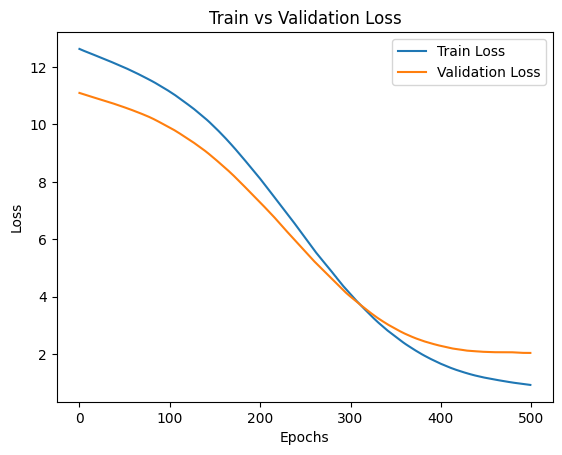

In [112]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, Flatten, Dense, Concatenate, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Datos de ejemplo
data = {
   'user_id': [6, 3, 7, 4, 6, 9, 2, 6, 7, 4, 3, 7, 7, 2, 5, 4, 1, 7, 5, 1, 4, 0, 9, 5, 8, 0, 9, 2, 6, 3, 8, 2, 4, 2, 6, 4, 8, 6, 1, 3, 8, 1, 9, 8, 9, 4, 1, 3, 6, 7],
   'book_id': [14, 2, 13, 16, 3, 17, 7, 3, 1, 5, 9, 3, 17, 11, 1, 9, 3, 13, 15, 14, 7, 13, 7, 15, 12, 17, 14, 12, 8, 14, 12, 0, 6, 8, 0, 11, 7, 10, 18, 16, 7, 2, 2, 0, 4, 9, 6, 8, 6, 8],
   'rating': [4, 2, 1, 5, 3, 4, 3, 3, 1, 3, 5, 3, 1, 5, 2, 3, 1, 2, 2, 4, 5, 3, 1, 4, 5, 4, 5, 5, 3, 5, 4, 5, 3, 3, 4, 2, 2, 5, 1, 5, 4, 4, 4, 4, 4, 3, 2, 4, 1, 1]
}

df = pd.DataFrame(data)
df['book_id'] = df['book_id'] - 1

# Parámetros
embedding_dim = 30
l2_reg = 0.01
dropout_rate = 0.5

# Crear el modelo
num_users = df['user_id'].nunique()
num_items = df['book_id'].nunique()

user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, 
                           embeddings_regularizer=l2(l2_reg), name='user_embedding')(user_input)
item_embedding = Embedding(input_dim=num_items, output_dim=embedding_dim, 
                           embeddings_regularizer=l2(l2_reg), name='item_embedding')(item_input)

# Flatten the embeddings
user_vec = Flatten(name='user_flatten')(user_embedding)
item_vec = Flatten(name='item_flatten')(item_embedding)

# Concatenate user and item vectors
concat = Concatenate()([user_vec, item_vec])

# Hidden layers with Dropout
dense_1 = Dense(32, activation='relu')(concat)
dropout_1 = Dropout(dropout_rate)(dense_1)
#dense_2 = Dense(64, activation='relu')(dropout_1)
#dropout_2 = Dropout(dropout_rate)(dense_2)
output = Dense(1)(dense_1)

# Crear el modelo
model = Model(inputs=[user_input, item_input], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

# Preparar los datos para el entrenamiento
X = [df['user_id'].values, df['book_id'].values]
y = df['rating'].values

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X, y, epochs=500, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# Graficar el loss de entrenamiento y validación
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss')
plt.show()


In [106]:
df.head()

,user_id,book_id,rating
0,6,13,4
1,3,1,2
2,7,12,1
3,4,15,5
4,6,2,3


In [115]:
# Función para predecir las calificaciones
def predict_rating(user_id, item_id):
    return model.predict([np.array([user_id]), np.array([item_id])])[0][0]

# Generación de candidatos
def candidate_generation(user_id, top_k=5):
    all_items = np.arange(num_items)
    predictions = model.predict([np.array([user_id] * num_items), all_items])
    top_items = np.argsort(predictions.flatten())[::-1][:top_k]
    return top_items

# Prueba de la predicción
pred_rating = predict_rating(1, 1)
print(f"Predicted rating for user 1 and item 3: {pred_rating}")

# Generar recomendaciones
for i in range(100, 200):
    top_items = candidate_generation(i, top_k=5)
    print(f"Top 3 recommendations for user {i}: {top_items}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted rating for user 1 and item 3: 1.8583555221557617


InvalidArgumentError: Graph execution error:

Detected at node functional_6_1/user_embedding_1/GatherV2 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\asyncio\windows_events.py", line 321, in run_forever

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\asyncio\base_events.py", line 608, in run_forever

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\asyncio\base_events.py", line 1936, in _run_once

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\asyncio\events.py", line 84, in _run

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\usuario\AppData\Local\Temp\ipykernel_26820\1451532105.py", line 17, in <module>

  File "C:\Users\usuario\AppData\Local\Temp\ipykernel_26820\1451532105.py", line 8, in candidate_generation

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 512, in predict

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 208, in one_step_on_data_distributed

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 198, in one_step_on_data

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 96, in predict_step

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\keras\src\layers\layer.py", line 901, in __call__

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\keras\src\models\functional.py", line 175, in call

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\keras\src\models\functional.py", line 560, in call

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\keras\src\layers\layer.py", line 901, in __call__

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\keras\src\layers\core\embedding.py", line 140, in call

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\keras\src\ops\numpy.py", line 4918, in take

  File "c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1967, in take

indices[0,0] = 100 is not in [0, 10)
	 [[{{node functional_6_1/user_embedding_1/GatherV2}}]] [Op:__inference_one_step_on_data_distributed_2062303]